In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['grid.color'] = 'white'


pathfile=r'/media/nicolascatz/4d767acb-7d35-42a5-b630-86a61f8774d0/nicolascatz/DATA/Projets/CRPN_DTI_AGING_DPAKNC/'

pathdata=pathfile+'data/'
pathdata_tractography=pathfile+'data/Corrected_Tractometry2025'
pathcsv=pathfile+'CSV/'
os.chdir(pathfile)



addtotitle='_112025_42s' # to specify the version of the data

Aging_INDICES = pd.read_csv('Subject_preproc' + addtotitle + '.csv')

CCx_list = ['CC_1','CC_2','CC_3','CC_4','CC_5','CC_6','CC_7']

DTI=np.zeros((42, 98, 7))  # 10 DTI metrics
for i, CC in enumerate(CCx_list):
    file_path = os.path.join(pathcsv, f'{CC}_FA{addtotitle}.csv')
    dfCCx = pd.read_csv(file_path, sep=",")

    DTI[:,:,i]=dfCCx.values  ## une variable DTI of shape subjects x nodes x n CCfgh




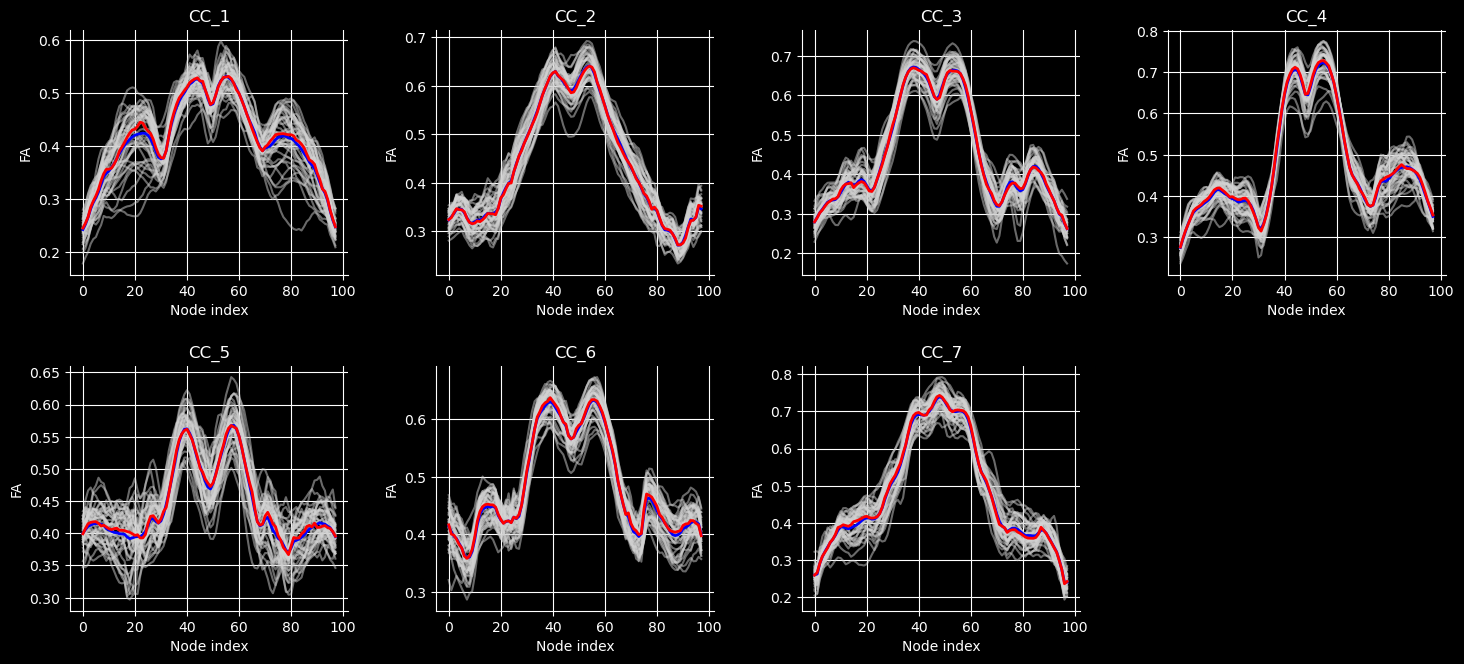

In [2]:
CCx_list = ['CC_1','CC_2','CC_3','CC_4','CC_5','CC_6','CC_7']
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
axs = axs.flatten()


for i, CCx in enumerate(CCx_list[0:7]):
    file_path = os.path.join(pathcsv, f'{CCx}_FA{addtotitle}.csv')

    axs[i].plot(DTI[:,:,i].T, color='lightgray', alpha=0.5)
    axs[i].plot(DTI[:,:,i].mean(axis=0), color='blue', linewidth=2)
    axs[i].plot(np.median(DTI[:,:,i], axis=0), color='red', linewidth=2)
    axs[i].set_xlabel('Node index')
    axs[i].set_ylabel('FA')
    axs[i].grid(True)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(CCx)
    
fig.delaxes(axs[7])
plt.tight_layout(pad=2.0)



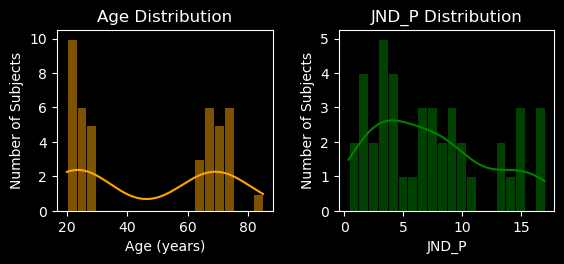

In [3]:
 # target var

import seaborn as sns

age = Aging_INDICES['age'].values
jnd = Aging_INDICES['JND_P'].values


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs = axs.flatten()

sns.histplot(age, bins=20, ax=axs[0],color='orange',kde=True)
axs[0].set_title('Age Distribution')
axs[0].set_xlabel('Age (years)')
axs[0].set_ylabel('Number of Subjects')
sns.histplot(jnd, bins=20, ax=axs[1],color='green',kde=True)
axs[1].set_title('JND_P Distribution')
axs[1].set_xlabel('JND_P')
axs[1].set_ylabel('Number of Subjects')
plt.tight_layout(pad=2.0)
plt.show()



test of Regression models with DTI data on CC6

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV, learning_curve
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, SelectFromModel
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.pipeline import Pipeline


age = Aging_INDICES['age'].values
jnd = Aging_INDICES['JND_P'].values

y=age



X_df = pd.DataFrame(DTI[:,:,i], columns=[f'{i+1}' for i in range(DTI[:,:,i].shape[1])])
X_df.head()

X=X_df

In [12]:


cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Lasso coefs 
all_coefs={}
# best models saved
all_best_lasso = {}
all_best_ridge = {}
# Store selected features
selected_features_lasso = {}
selected_features_ridge = {}

# Loop over CCx datasets
CCx_list = ['CC_1','CC_2','CC_3','CC_4','CC_5','CC_6','CC_7']




# --------------------------
# 1) LASSO pipeline
# --------------------------
pipe_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', 'passthrough'),
    ('regressor', Lasso(max_iter=10000))
])

param_grid_lasso = [
    {
        'feature_selection': [VarianceThreshold()],
        'feature_selection__threshold': [0.01, 0.05, 0.08],
        'regressor__alpha': [0.01,0.1, 1.0, 10.0, 100]
    },
    {
        'feature_selection': [SelectKBest(score_func=f_regression)],
        'feature_selection__k': [5, 10, 15, 20],
        'regressor__alpha': [0.01,0.1, 1.0, 10.0, 100]
    },
    {
        'feature_selection': [SelectFromModel(LassoCV(max_iter=10000, random_state=42))],
        'feature_selection__max_features': [5, 10, 15, 20],
        'regressor__alpha': [0.01,0.1, 1.0, 10.0, 100]
    }
]

grid_lasso = GridSearchCV(
    estimator=pipe_lasso,
    param_grid=param_grid_lasso,
    cv=cv.split(X, y),
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_lasso.fit(X, y)

print(f"\n===== {CCx} - LASSO =====")
print("Best params:", grid_lasso.best_params_)
print("Best CV R²:", grid_lasso.best_score_)

# Get final Lasso model from the pipeline
best_lasso = grid_lasso.best_estimator_
all_best_lasso[CCx] = best_lasso

# Get selected feature names after preprocessing + selection
feature_selector = best_lasso.named_steps['feature_selection']

if hasattr(feature_selector, 'get_support'):
    # For selectors like VarianceThreshold, SelectKBest, SelectFromModel
    mask = feature_selector.get_support()
    selected_features = X.columns[mask]
else:
    # If no selection step ("passthrough")
    selected_features = X.columns

# Save selected features externally
selected_features_lasso[CCx] = list(selected_features)

# Get coefficients
lasso_coef = best_lasso.named_steps['regressor'].coef_
# Build dataframe of coefficients
coef_df = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": lasso_coef
}).sort_values(by="Coefficient", ascending=False)
print("Intercept:", best_lasso.named_steps['regressor'].intercept_)
#print(coef_df.head(10))  # top 10 features
all_coefs[CCx]=coef_df


# --------------------------
# 2) RIDGE pipeline
# --------------------------
pipe_ridge = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', 'passthrough'),
    ('regressor', Ridge(max_iter=10000))
])

param_grid_ridge = [
    {
        'feature_selection': [VarianceThreshold()],
        'feature_selection__threshold': [0.01, 0.05, 0.08],
        'regressor__alpha': [0.01,0.1, 1.0, 10.0, 100]
    },
    {
        'feature_selection': [SelectKBest(score_func=f_regression)],
        'feature_selection__k': [5, 10, 15, 20],
        'regressor__alpha': [0.01,0.1, 1.0, 10.0, 100]
    },
    {
        'feature_selection': [SelectFromModel(RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100], store_cv_values=True))],            
        'feature_selection__max_features': [5, 10, 15, 20],
        'regressor__alpha': [0.01,0.1, 1.0, 10.0, 100]
    }
]

grid_ridge = GridSearchCV(
    estimator=pipe_ridge,
    param_grid=param_grid_ridge,
    cv=cv.split(X, y),
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_ridge.fit(X, y)
best_ridge = grid_ridge.best_estimator_
all_best_ridge[CCx] = best_ridge

print(f"\n===== {CCx} - RIDGE =====")
print("Best params:", grid_ridge.best_params_)
print("Best CV R²:", grid_ridge.best_score_)

feature_selector_ridge = best_ridge.named_steps['feature_selection']
if hasattr(feature_selector_ridge, 'get_support'):
    mask_ridge = feature_selector_ridge.get_support()
    selected_features_r = X.columns[mask_ridge]
else:
    selected_features_r = X.columns

# Save selected features externally
selected_features_ridge[CCx] = list(selected_features_r)

# --------------------------
# Comparing the 2 models
# --------------------------

# comparing R2 scores
if grid_lasso.best_score_ > grid_ridge.best_score_:
    print(f" RESULTS on R2 :  For {CCx}, LASSO performed better.")
else:
    print(f" RESULTS on R2: For {CCx}, RIDGE performed better.")


Fitting 5 folds for each of 55 candidates, totalling 275 fits

===== CC_7 - LASSO =====
Best params: {'feature_selection': SelectFromModel(estimator=LassoCV(max_iter=10000, random_state=42)), 'feature_selection__max_features': 5, 'regressor__alpha': 1.0}
Best CV R²: 0.14712964793973418
Intercept: 46.427498077983344


TypeError: _BaseRidgeCV.__init__() got an unexpected keyword argument 'store_cv_values'

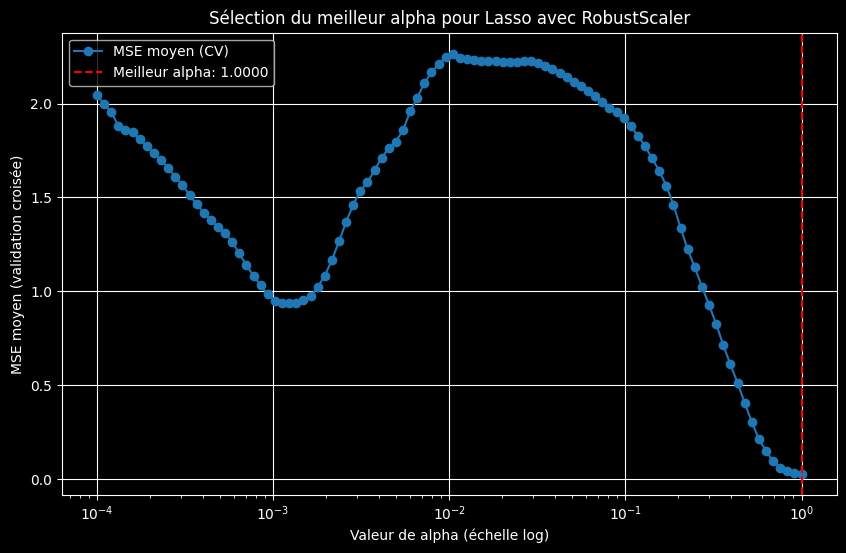

Meilleur alpha: 1.0
MSE sur le test: 392.3877008379267
R² sur le test: 0.2085411681888525
Nombre de variables sélectionnées: 13


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Supposons que X et y soient déjà définis (42 lignes, 98 variables)
# X = vos données (42, 98)
# y = votre variable cible (42,)

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création de la pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('lasso', Lasso(max_iter=10000))
])

# Définition de la grille de paramètres pour alpha
param_grid = {'lasso__alpha': np.logspace(-4, 0, 100)}

# Initialisation de GridSearchCV
grid_lasso = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Ajustement du modèle
grid_lasso.fit(X_train, y_train)

# Récupération des résultats de la validation croisée
results = grid_lasso.cv_results_
alphas = param_grid['lasso__alpha']
mean_scores = -results['mean_test_score']  # Conversion en MSE positif

# Meilleur modèle et prédictions
best_model = grid_lasso.best_estimator_
y_pred = best_model.predict(X_test)

# Métriques
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
num_non_zero = np.sum(best_model.named_steps['lasso'].coef_ != 0)

# Tracé des résultats
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, mean_scores, marker='o', label='MSE moyen (CV)')
plt.axvline(grid_search.best_params_['lasso__alpha'], color='r', linestyle='--',
            label=f'Meilleur alpha: {grid_search.best_params_["lasso__alpha"]:.4f}')
plt.xlabel('Valeur de alpha (échelle log)')
plt.ylabel('MSE moyen (validation croisée)')
plt.title('Sélection du meilleur alpha pour Lasso avec RobustScaler')
plt.legend()
plt.grid(True)
plt.show()

# Affichage des résultats
print("Meilleur alpha:", grid_search.best_params_['lasso__alpha'])
print("MSE sur le test:", mse)
print("R² sur le test:", r2)
print("Nombre de variables sélectionnées:", num_non_zero)
